In [1]:
import numpy as np
import yaml
from pyuvdata import UVBeam
from beam_show_ops import *
from sparse_beam import sparse_beam

# Plot all known beams 

Beams are defined in beams.yaml

airy
example_uan
horn_uan
horntest
rhino1
rhino1_sparse
vivaldi
vivaldi_sparse


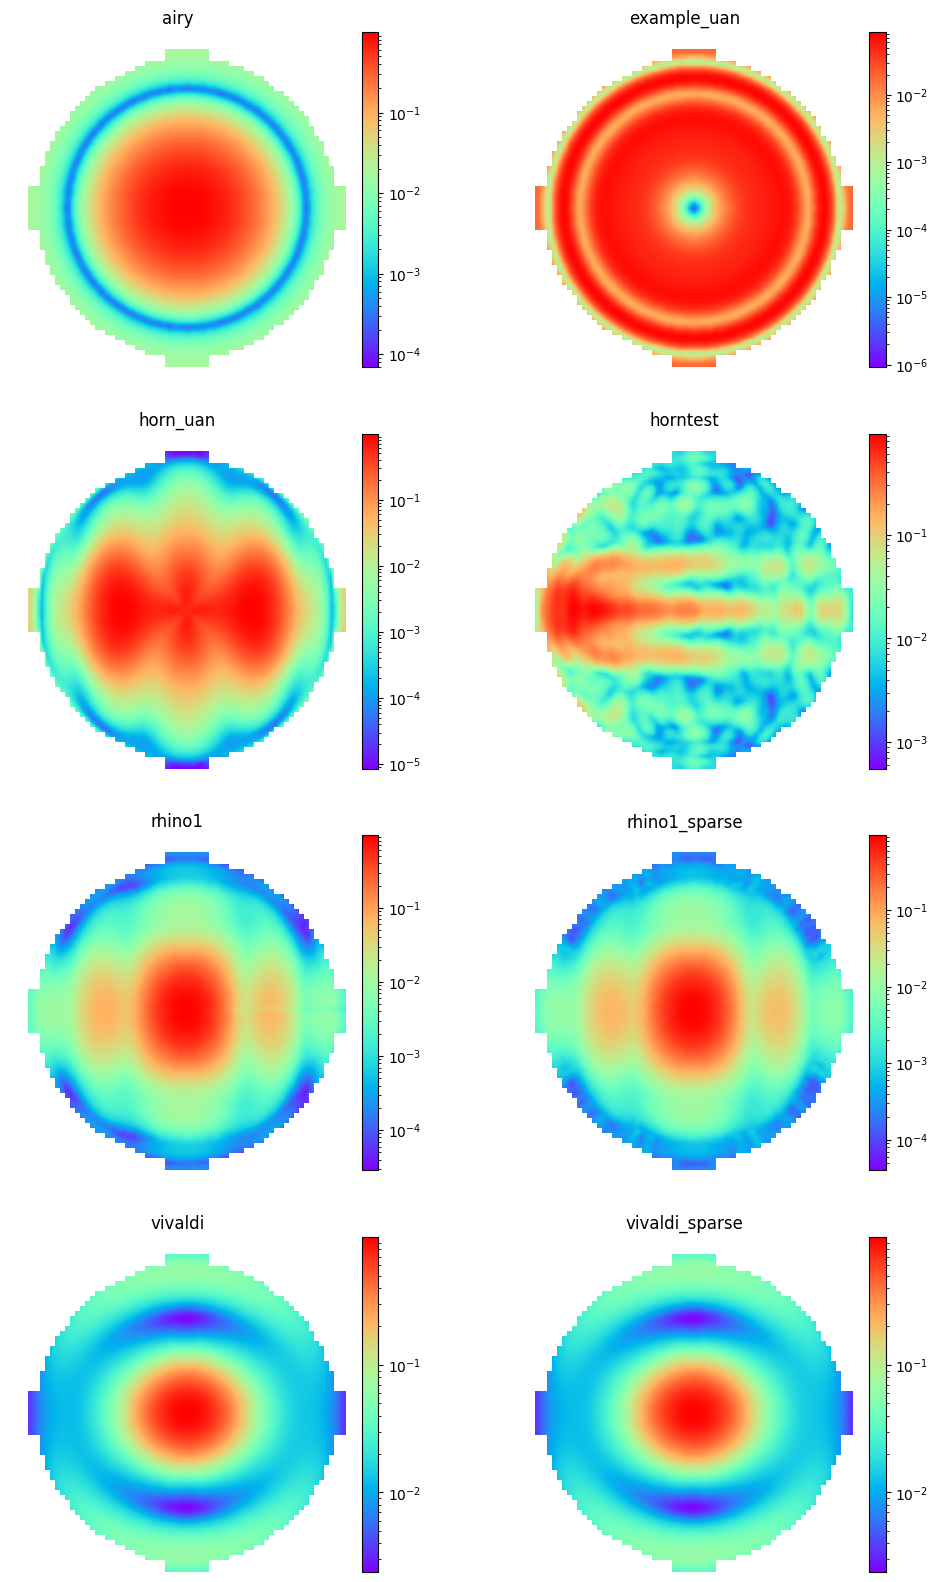

In [6]:
with open('beams.yaml', 'r') as file:
    beams = yaml.safe_load(file)


num_beams = len(beams)

ncols = 2
nrows = num_beams//ncols
if nrows*ncols < num_beams: nrows += 1

plt.figure(figsize=(12, 20))
for i, beam in enumerate(sorted(beams)):
    print(beam)
    plt.subplot(nrows, ncols, i+1)
    #plt.plot([0, 1], [0, 1])
    plot_beam(load_beam(beams[beam]), 60e6, beam)

    

